In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.errors import InvalidArgumentError
import tensorflow as tf

# Tensorflow GPU settings
# gpu_options = tf.GPUOptions(allow_growth=True)#per_process_gpu_memory_fraction=0.5)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle

from scipy import interpolate

from atlasify import atlasify
import pickle
import os

In [2]:
sig = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_VVZ_RD.arrow')
sig['is_signal'] = True
# sig = sig[sig.SR == 2]

bg = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_FULLBG_RD.arrow')
bg['is_signal'] = False
# bg = bg[bg.SR == 2]

In [3]:
train_feats_raw = sorted([f for f in sig.columns if f not in ['index', 'wgt', 'is_signal', 
                                                              'Zcand_mass', 'chisq']])

train_feat_sets = [train_feats_raw, 
                   [f for f in train_feats_raw if f not in ['Wlep1_phi', 'Wlep2_phi', 'Zlep1_phi', 'Zlep2_phi']],
                   [f for f in train_feats_raw if f not in ['MET', 'METSig']],
                   [f for f in train_feats_raw if f not in ['pt_1', 'pt_2', 'pt_3', 'pt_4']],
                   [f for f in train_feats_raw if f not in ['Njet', 'Nlep']]
                  ]

In [4]:
# Normalize training features
X = pd.concat([sig[train_feats_raw], bg[train_feats_raw]], ignore_index=True)

min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler.fit(X)

for df in [sig, bg]:
    df[train_feats_raw] = min_max_scaler.transform(df[train_feats_raw])

In [5]:
# Load per-background models
models_dir = 'models/background_id_models/'

background_classifiers = {'ZZ': 1, 'Zjets': 2, 'WZ': 1, 'ttZ': 0, 'other': 1}

for bc_name in background_classifiers:
    bc_index = background_classifiers[bc_name]
    
    classifier = keras.models.load_model((models_dir + 'classifier_' + bc_name 
                                          + '_train_feat_test_' + str(bc_index)))
    sig['classifier_' + bc_name + '_score'] = classifier.predict(sig[train_feat_sets[bc_index]], 
                                                                    batch_size=10000)
    bg['classifier_' + bc_name + '_score'] = classifier.predict(bg[train_feat_sets[bc_index]], 
                                                                   batch_size=10000)

2022-01-31 14:02:14.404519: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-31 14:02:14.406847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-01-31 14:02:14.406927: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-31 14:02:14.406970: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-01-31 14:02:14.407001: I tensorflow/stream_executor/plat

In [11]:
# Cut to 4l-DF signal region
bg = bg[bg.SR == 1]
sig = sig[sig.SR == 1]

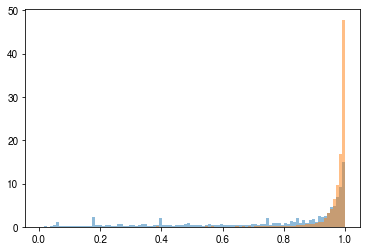

In [12]:
_, b, _ = plt.hist(bg.classifier_ZZ_score, bins=100, weights=bg.wgt, density=True, alpha=0.5)
plt.hist(sig.classifier_ZZ_score, bins=b, weights=sig.wgt, density=True, alpha=0.5)

plt.show()

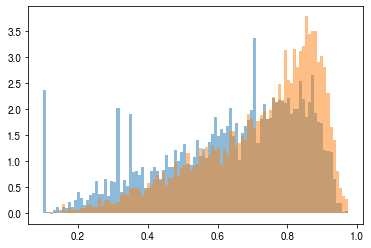

In [13]:
_, b, _ = plt.hist(bg.classifier_Zjets_score, bins=100, weights=bg.wgt, density=True, alpha=0.5)
plt.hist(sig.classifier_Zjets_score, bins=b, weights=sig.wgt, density=True, alpha=0.5)

plt.show()

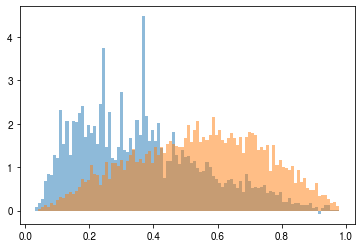

In [14]:
_, b, _ = plt.hist(bg.classifier_WZ_score, bins=100, weights=bg.wgt, density=True, alpha=0.5)
plt.hist(sig.classifier_WZ_score, bins=b, weights=sig.wgt, density=True, alpha=0.5)

plt.show()

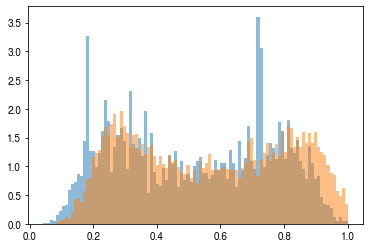

In [15]:
_, b, _ = plt.hist(bg.classifier_ttZ_score, bins=100, weights=bg.wgt, density=True, alpha=0.5)
plt.hist(sig.classifier_ttZ_score, bins=b, weights=sig.wgt, density=True, alpha=0.5)

plt.show()

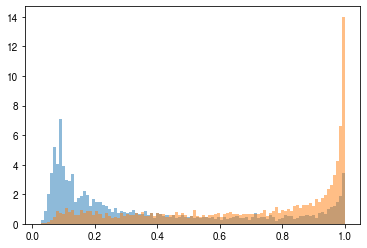

In [16]:
_, b, _ = plt.hist(bg.classifier_other_score, bins=100, weights=bg.wgt, density=True, alpha=0.5)
plt.hist(sig.classifier_other_score, bins=b, weights=sig.wgt, density=True, alpha=0.5)

plt.show()

# Scan model outputs

In [17]:
def region_sig(s, b):
    if s == 0:
        return 0
    return np.sqrt(2 * ((s + b) * np.log(1 + s / b) - s))

n_bg = sum(bg.wgt)
n_sig = sum(sig.wgt)

print('There are', n_bg, 'background events')
print('There are', n_sig, 'signal events')
print('')
print('S/B =', n_sig/n_bg)
print('Starting significance is', region_sig(n_sig, n_bg), 'sigma')
print('Corresponds to', np.sqrt(2.0) * region_sig(n_sig, n_bg), 'sigma')

There are 38.30702696298086 background events
There are 6.760975084128499 signal events

S/B = 0.17649438288860603
Starting significance is 1.0623934062436122 sigma
Corresponds to 1.5024511636854656 sigma


In [18]:
bg_classifier_score_feats = ['classifier_' + bc + '_score' for bc in background_classifiers]
combined_train_feats_raw = train_feats_raw + bg_classifier_score_feats

combined_train_feat_sets = [combined_train_feats_raw, 
                            [f for f in combined_train_feats_raw if f not in bg_classifier_score_feats],
                            [f for f in combined_train_feats_raw if f not in ['Wlep1_phi', 'Wlep2_phi', 
                                                                              'Zlep1_phi', 'Zlep2_phi']],
                            [f for f in combined_train_feats_raw if f not in ['MET', 'METSig']],
                            [f for f in combined_train_feats_raw if f not in ['pt_1', 'pt_2', 'pt_3', 'pt_4']],
                            [f for f in combined_train_feats_raw if f not in ['Njet', 'Nlep']]
                           ]

In [26]:
# Regenerate test samples
_, sig_test = train_test_split(sig[combined_train_feats_raw + ['wgt']], train_size=0.5, random_state=314)
_, bg_test = train_test_split(bg[combined_train_feats_raw + ['wgt']], train_size=0.5, random_state=314)

n_sig_test = sum(sig_test.wgt)
n_bg_test = sum(bg_test.wgt)

x_test = pd.concat([sig_test[combined_train_feats_raw], bg_test[combined_train_feats_raw]])
y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])
w_test = pd.Series(np.concatenate([(n_sig_test + n_bg_test) / n_sig_test * sig_test['wgt'], 
                                   (n_sig_test + n_bg_test) / n_bg_test * bg_test['wgt']]))

In [30]:
dir_base = 'SR_4l_DF_models/'
model_dir = 'models/' + dir_base
plot_dir = 'plots/' + dir_base
model_name_group = 'classifier_train_feat_test'

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [27]:
completed_tests = [model_dir + t for t in os.listdir(model_dir) 
                   if t.startswith(model_name_group) and t.endswith('_history.pkl')]
completed_tests = [t.replace('_history.pkl', '') for t in completed_tests]
completed_tests

['models/SR_4l_DF_models/classifier_train_feat_test_0',
 'models/SR_4l_DF_models/classifier_train_feat_test_1',
 'models/SR_4l_DF_models/classifier_train_feat_test_2',
 'models/SR_4l_DF_models/classifier_train_feat_test_3',
 'models/SR_4l_DF_models/classifier_train_feat_test_4',
 'models/SR_4l_DF_models/classifier_train_feat_test_5']

Generate ROC curves

In [28]:
models = [None] * len(completed_tests)

for i, test in enumerate(completed_tests):
    models[i] = keras.models.load_model(test)
    
    x_test['output_test_' + str(i)] = models[i].predict(x_test[combined_train_feat_sets[i]], batch_size=10000)
    sig_test['output_test_' + str(i)] = models[i].predict(sig_test[combined_train_feat_sets[i]], batch_size=10000)
    bg_test['output_test_' + str(i)] = models[i].predict(bg_test[combined_train_feat_sets[i]], batch_size=10000)

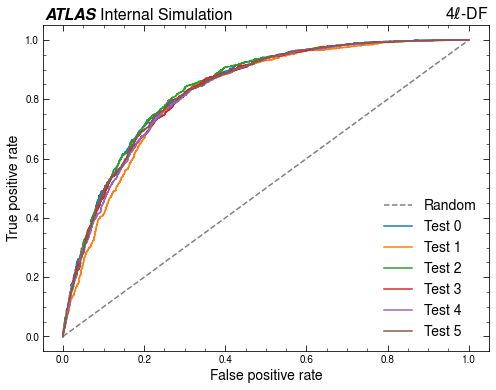

In [34]:
# Generate ROC curves
plt.figure(figsize=(8, 6))

plt.plot([0, 1], [0, 1], ls='--', color='grey', label='Random')

for i, test in enumerate(completed_tests):
    fpr, tpr, _ = roc_curve(y_test, x_test['output_test_' + str(i)], sample_weight=w_test)
    
    plt.plot(fpr, tpr, label='Test ' + str(i))
    
plt.legend(fontsize=14)
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('4$\ell$-DF', fontsize=16, loc='right')

atlasify('Internal Simulation', outside=True)

plt.savefig(plot_dir + model_name_group + '.png', pad_inches=0.05, bbox_inches='tight')
plt.savefig(plot_dir + model_name_group + '.pdf', pad_inches=0.05, bbox_inches='tight')

Generate training history plots

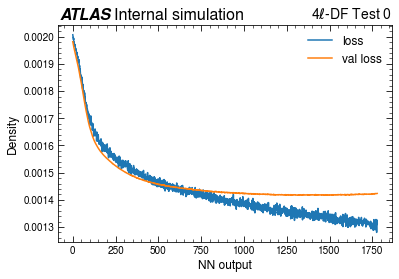

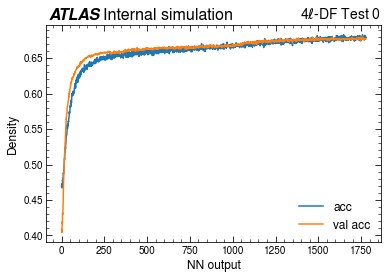

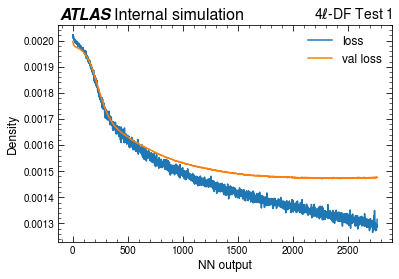

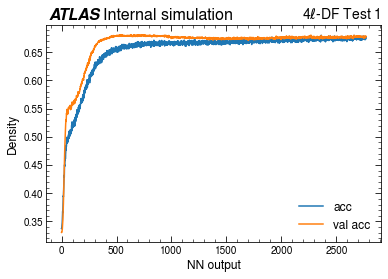

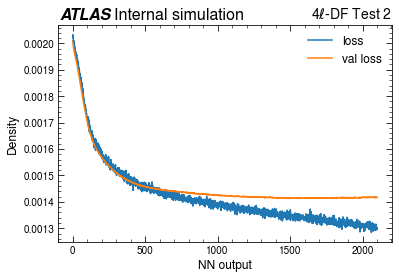

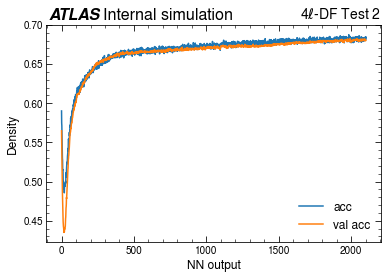

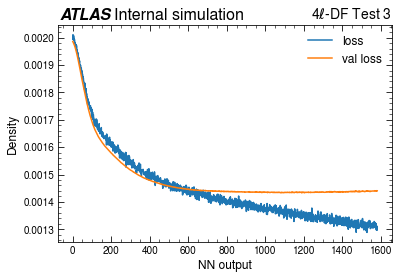

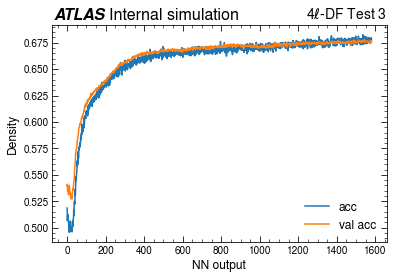

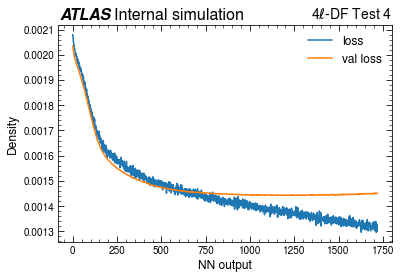

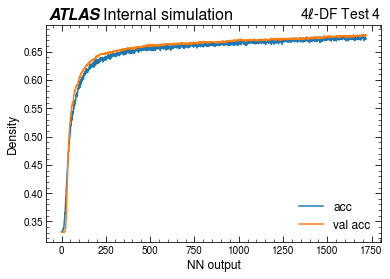

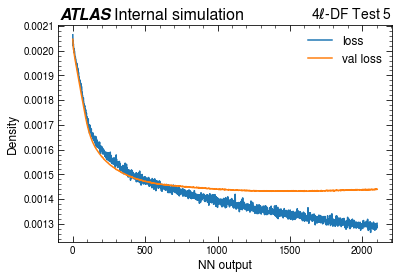

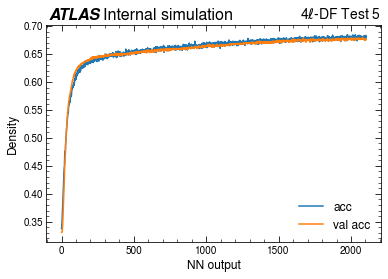

In [36]:
# Generate training history plots

for i, test in enumerate(completed_tests):
    history_plot_dir = plot_dir + 'train_feat_test/'
    if not os.path.exists(history_plot_dir):
        os.makedirs(history_plot_dir)
    
    plt.figure(figsize=(6, 4))
    
    with open(test + '_history.pkl', 'rb') as f:
        history = pickle.load(f)
        
    # Loss
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val loss')
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('4$\ell$-DF Test ' + str(i), fontsize=14, loc='right')
    
    plt.savefig(history_plot_dir + 'test_' + str(i) + '_loss.png', 
            pad_inches=0.05, bbox_inches='tight')
    plt.savefig(history_plot_dir + '/test_' + str(i) + '_loss.pdf', 
            pad_inches=0.05, bbox_inches='tight')
    
    plt.show()
    
    # Accuracy
    plt.plot(history['accuracy'], label='acc')
    plt.plot(history['val_accuracy'], label='val acc')
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('4$\ell$-DF Test ' + str(i), fontsize=14, loc='right')
    
    plt.savefig(history_plot_dir + '/test_' + str(i) + '_acc.png', pad_inches=0.05, bbox_inches='tight')
    plt.savefig(history_plot_dir + '/test_' + str(i) + '_acc.pdf', pad_inches=0.05, bbox_inches='tight')

Generate signal vs background histograms

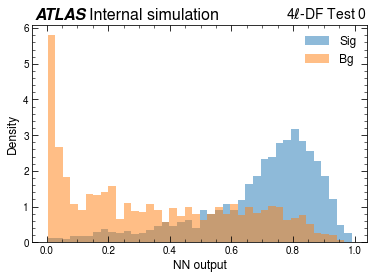

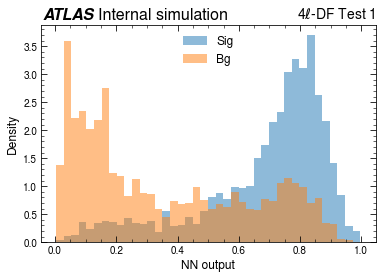

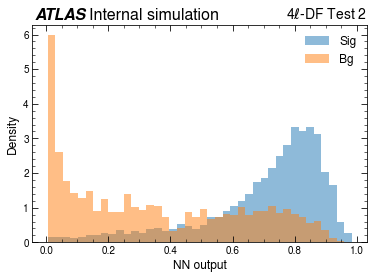

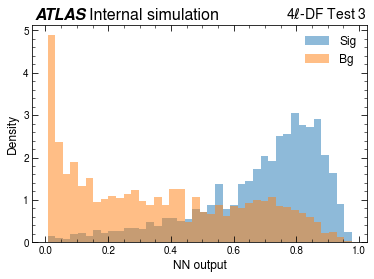

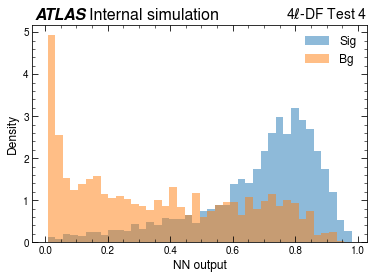

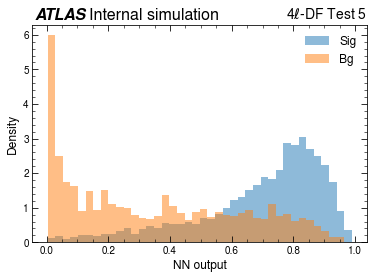

In [38]:
# Generate signal vs background histograms

for i, test in enumerate(completed_tests):
    plt.figure(figsize=(6, 4))
    
    _, b, _ = plt.hist(sig_test['output_test_' + str(i)], bins=40, weights=sig_test.wgt, label='Sig', 
                       density=True, alpha=0.5)
    plt.hist(bg_test['output_test_' + str(i)], bins=b, weights=bg_test.wgt, label='Bg', 
             density=True, alpha=0.5)
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('4$\ell$-DF Test ' + str(i), fontsize=14, loc='right')
    
    plt.savefig(history_plot_dir + 'test_' + str(i) + '_output.png', 
            pad_inches=0.05, bbox_inches='tight')
    plt.savefig(history_plot_dir + 'test_' + str(i) + '_output.pdf', 
            pad_inches=0.05, bbox_inches='tight')

Generate significance scans

Test 0
Max observed significance: 1.1155251194260407 sigma at cut of 0.68
Corresponds to 2.2310502388520814 sigma with full dataset


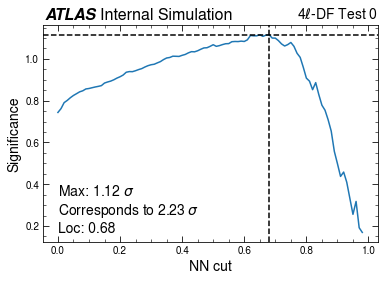

Test 1
Max observed significance: 1.0796420079600162 sigma at cut of 0.63
Corresponds to 2.1592840159200324 sigma with full dataset


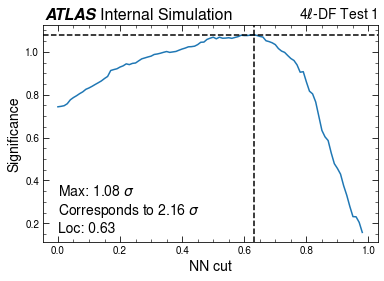

Test 2
Max observed significance: 1.1226861345773707 sigma at cut of 0.65
Corresponds to 2.2453722691547413 sigma with full dataset


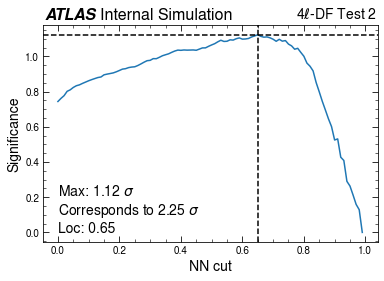

Test 3
Max observed significance: 1.0760336593551914 sigma at cut of 0.61
Corresponds to 2.1520673187103827 sigma with full dataset


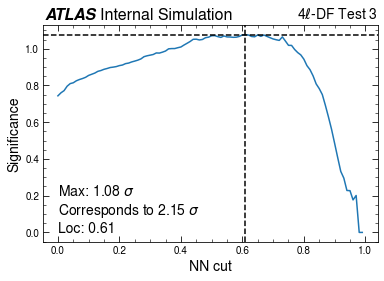

Test 4
Max observed significance: 1.0831379207755425 sigma at cut of 0.58
Corresponds to 2.166275841551085 sigma with full dataset


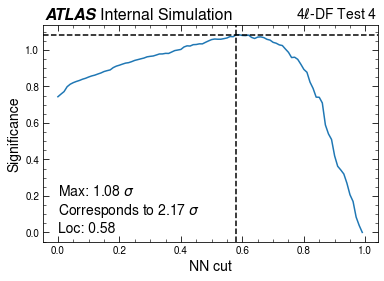

Test 5
Max observed significance: 1.1016619593795811 sigma at cut of 0.6
Corresponds to 2.2033239187591622 sigma with full dataset


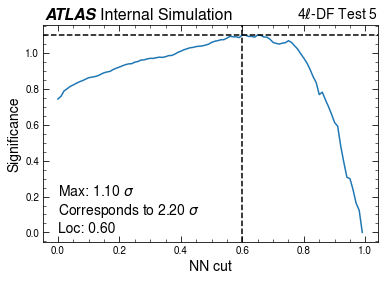

In [47]:
for test_i, test in enumerate(completed_tests):
    # Perform significance scan
    n_sig_pts = 100

    nn_cuts = np.arange(0.0, 1.0, 1.0/n_sig_pts)
    significances = [float('nan')]*n_sig_pts

    max_sig_loc = 0
    max_sig = 0

    for i, nn_cut in enumerate(nn_cuts):
        n_bg = sum(bg_test[bg_test['output_test_' + str(test_i)] > nn_cut].wgt)
        n_sig = sum(sig_test[sig_test['output_test_' + str(test_i)] > nn_cut].wgt)

        try:
            current_sig = region_sig(n_sig, n_bg)
        except ZeroDivisionError:
            current_sig = float('nan')
        significances[i] = current_sig

        if current_sig > max_sig:
            max_sig = current_sig
            max_sig_loc = nn_cut

    print('Test ' + str(test_i))
    print('Max observed significance:', max_sig, 'sigma at cut of', max_sig_loc)
    print('Corresponds to', 2*max_sig, 'sigma with full dataset')
    
    # Plot scan
    plt.figure(figsize=(6, 4))
    plt.plot(nn_cuts, significances)

    plt.axhline(y=max_sig, color='black', ls='--')
    plt.axvline(x=max_sig_loc, color='black', ls='--')

    plt.ylabel('Significance', fontsize=14)
    plt.xlabel('NN cut', fontsize=14)
    plt.title('4$\ell$-DF Test ' + str(test_i), loc='right', fontsize=14)

    plt.text(min(nn_cuts), min(significances), 
             'Max: %.2f $\sigma$\nCorresponds to %.2f $\sigma$\nLoc: %.2f'%(max_sig, 2*max_sig, max_sig_loc),
             fontsize=14)

    atlasify('Internal Simulation', outside=True)

    local_plot_name = 'sig_scan_test_' + str(test_i)
    plt.savefig(plot_dir + local_plot_name + '.png')
    plt.savefig(plot_dir + local_plot_name + '.pdf')
    plt.show()

Test 0
Max observed significance: 1.1155251194260407 sigma at cut of 0.68
Corresponds to 2.2310502388520814 sigma with full dataset
Test 1
Max observed significance: 1.1155251194260407 sigma at cut of 0.68
Corresponds to 2.2310502388520814 sigma with full dataset
Test 2
Max observed significance: 1.1226861345773707 sigma at cut of 0.65
Corresponds to 2.2453722691547413 sigma with full dataset
Test 3
Max observed significance: 1.1226861345773707 sigma at cut of 0.65
Corresponds to 2.2453722691547413 sigma with full dataset
Test 4
Max observed significance: 1.1226861345773707 sigma at cut of 0.65
Corresponds to 2.2453722691547413 sigma with full dataset
Test 5
Max observed significance: 1.1226861345773707 sigma at cut of 0.65
Corresponds to 2.2453722691547413 sigma with full dataset


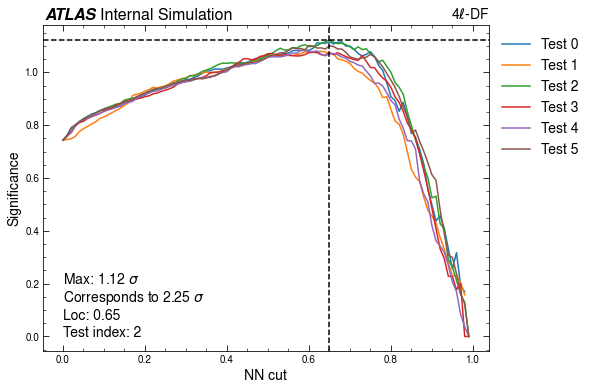

In [59]:
# Plot combined significance scan
plt.figure(figsize=(8, 6))

max_sig_loc = 0
max_sig_index = 0
max_sig = 0

for test_i, test in enumerate(completed_tests):
    # Perform significance scan
    n_sig_pts = 100

    nn_cuts = np.arange(0.0, 1.0, 1.0/n_sig_pts)
    significances = [float('nan')]*n_sig_pts

    for i, nn_cut in enumerate(nn_cuts):
        n_bg = sum(bg_test[bg_test['output_test_' + str(test_i)] > nn_cut].wgt)
        n_sig = sum(sig_test[sig_test['output_test_' + str(test_i)] > nn_cut].wgt)

        try:
            current_sig = region_sig(n_sig, n_bg)
        except ZeroDivisionError:
            current_sig = float('nan')
        significances[i] = current_sig

        if current_sig > max_sig:
            max_sig = current_sig
            max_sig_loc = nn_cut
            max_sig_index = test_i

    print('Test ' + str(test_i))
    print('Max observed significance:', max_sig, 'sigma at cut of', max_sig_loc)
    print('Corresponds to', 2*max_sig, 'sigma with full dataset')
    
    # Plot scan
    plt.plot(nn_cuts, significances, label='Test ' + str(test_i))

plt.axhline(y=max_sig, color='black', ls='--')
plt.axvline(x=max_sig_loc, color='black', ls='--')

plt.ylabel('Significance', fontsize=14)
plt.xlabel('NN cut', fontsize=14)
plt.title('4$\ell$-DF', loc='right', fontsize=14)

plt.text(min(nn_cuts), min(significances), 
         ('Max: %.2f $\sigma$\nCorresponds to %.2f $\sigma$\nLoc: %.2f'%(max_sig, 2*max_sig, max_sig_loc)
          +'\nTest index: %i'%(max_sig_index)),
         fontsize=14)

plt.legend(fontsize=14, bbox_to_anchor=(1.0, 1.0))
atlasify('Internal Simulation', outside=True)

local_plot_name = 'sig_scan_combined'
plt.savefig(plot_dir + local_plot_name + '.png')
plt.savefig(plot_dir + local_plot_name + '.pdf')